In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import Metric
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import Metric
from tensorflow.keras.regularizers import l2


In [ ]:
# Подготовка данных для модели
y_labels = pd.read_csv('/content/drive/MyDrive/y_labels_100thsnd.csv')

cnn_arrays = np.load('/content/drive/MyDrive/shuffled_combined_100thsnd.npz')
X_ts = cnn_arrays['X']
ids_ts = cnn_arrays['ids']

In [6]:
# Создание индексов для корректного разделения
indices = np.arange(len(X_ts))
# Стратифицированное разделение с сохранением индексов
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_ts,
    y_labels['main_class'].values,
    indices,
    #X_fats,
    test_size=0.2,
    stratify=y_labels['main_class'],
    random_state=42
)

In [7]:
# Кодирование целевых переменных
ohe_main = OneHotEncoder(sparse_output=False)
y_main = ohe_main.fit_transform(y_labels[['main_class']])

In [8]:
# Вычисление весов классов до SMOTE
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_labels['main_class']),
    y=y_labels['main_class']
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: np.float64(0.6947000327833024),
 1: np.float64(5.210819672131148),
 2: np.float64(0.43929607960565714),
 3: np.float64(1.2142875334267158),
 4: np.float64(3.721287804878049)}

In [9]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[['ECLIPSING' 21962]
 ['ERUPTIVE' 2928]
 ['PULSATING' 34731]
 ['ROTATING' 12565]
 ['cataclysmic' 4100]]


In [10]:
n_samples, timesteps, features = X_train.shape

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
# Коллбэк для сохранения по F1
checkpoint_f1 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_f1.keras',
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Коллбэк для сохранения по val_loss
checkpoint_loss = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_loss.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    TensorBoard(log_dir='./logs'),
    checkpoint_f1,
    checkpoint_loss
]

In [13]:
# Преобразование меток в one-hot
y_train_resampled_onehot = ohe_main.transform(pd.DataFrame(y_train, columns=['main_class']))
y_val_onehot = ohe_main.transform(pd.DataFrame(y_val, columns=['main_class']))

In [ ]:
class TemporalScaler:
    def __init__(self):
        self.scalers = []

    def fit(self, X_train):
        """Обучение на тренировочных данных"""
        self.scalers = []
        for feat_idx in range(X_train.shape[2]):
            scaler = StandardScaler()
            scaler.fit(X_train[:, :, feat_idx].reshape(-1, 1))
            self.scalers.append(scaler)
        return self

    def transform(self, X):
        """Применение к любым данным"""
        X_scaled = np.zeros_like(X)
        for feat_idx in range(X.shape[2]):
            X_scaled[:, :, feat_idx] = self.scalers[feat_idx].transform(
                X[:, :, feat_idx].reshape(-1, 1)
            ).reshape(X.shape[0], X.shape[1])
        return X_scaled

# Использование
scaler = TemporalScaler()
scaler.fit(X_train) 

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [15]:
def build_enhanced_model(input_shape, num_classes):
    # Вход для временных рядов
    ts_input = Input(shape=input_shape, name='ts_input')

    # CNN-ветвь
    x = Conv1D(128, 7, padding='same')(ts_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = Conv1D(256, 7, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)

    # Сохраняем тензор для residual connection
    residual = x

    # Transformer блок
    x = MultiHeadAttention(num_heads=8, key_dim=32)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + residual)

    # LSTM блок
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = GlobalAveragePooling1D()(x)

    # Классификатор
    output = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    output = Dropout(0.5)(output)
    output = Dense(num_classes, activation='softmax')(output)

    return Model(inputs=ts_input, outputs=output)

In [22]:
# Компиляция модели
model = build_enhanced_model(
    input_shape=(timesteps, features),
    num_classes=len(ohe_main.categories_[0])
)
model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[F1Score(average='macro')]
)

In [23]:
# Обучение модели
history = model.fit(
    X_train_scaled,
    y_train_resampled_onehot,
    epochs=50,
    batch_size=128,
    #class_weight=class_weight_dict,
    validation_data=([X_val_scaled], y_val_onehot),
    callbacks=callbacks
)

Epoch 1/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - f1_score: 0.3612 - loss: 1.6479
Epoch 1: val_f1_score did not improve from 0.50593

Epoch 1: val_loss did not improve from 0.97498
596/596 ━━━━━━━━━━━━━━━━━━━━ 104s 159ms/step - f1_score: 0.3613 - loss: 1.6472 - val_f1_score: 0.4746 - val_loss: 1.0143
Epoch 2/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - f1_score: 0.4971 - loss: 0.9963
Epoch 2: val_f1_score improved from 0.50593 to 0.51167, saving model to /content/drive/MyDrive/best_f1.keras

Epoch 2: val_loss improved from 0.97498 to 0.96929, saving model to /content/drive/MyDrive/best_loss.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 145s 165ms/step - f1_score: 0.4971 - loss: 0.9963 - val_f1_score: 0.5117 - val_loss: 0.9693
Epoch 3/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - f1_score: 0.5152 - loss: 0.9675
Epoch 3: val_f1_score improved from 0.51167 to 0.53118, saving model to /content/drive/MyDrive/best_f1.keras

Epoch 3: val_loss improved from 0.96929 to 0.93618, saving model to 

In [ ]:
# Найти индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1,
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 24
Train F1: 0.6156
Train loss: 0.8188
Validation F1: 0.5923
Validation Loss: 0.8668


In [25]:
pd.DataFrame(history.history).to_csv('/content/drive/MyDrive/history.csv')

596/596 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step


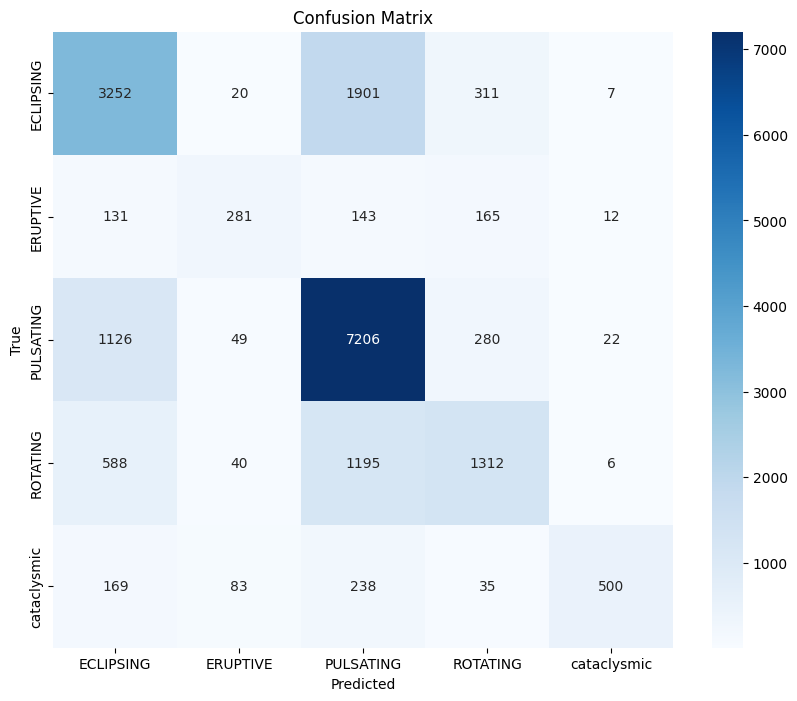

In [ ]:
# Получение предсказаний
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

# Создание confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Визуализация с нормализацией
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
           annot=True,
           fmt='d',
           cmap='Blues',
           xticklabels=ohe_main.categories_[0],
           yticklabels=ohe_main.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   ECLIPSING     0.6175    0.5922    0.6046      5491
    ERUPTIVE     0.5941    0.3839    0.4664       732
   PULSATING     0.6745    0.8299    0.7442      8683
    ROTATING     0.6239    0.4177    0.5004      3141
 cataclysmic     0.9141    0.4878    0.6361      1025

    accuracy                         0.6581     19072
   macro avg     0.6848    0.5423    0.5903     19072
weighted avg     0.6596    0.6581    0.6474     19072



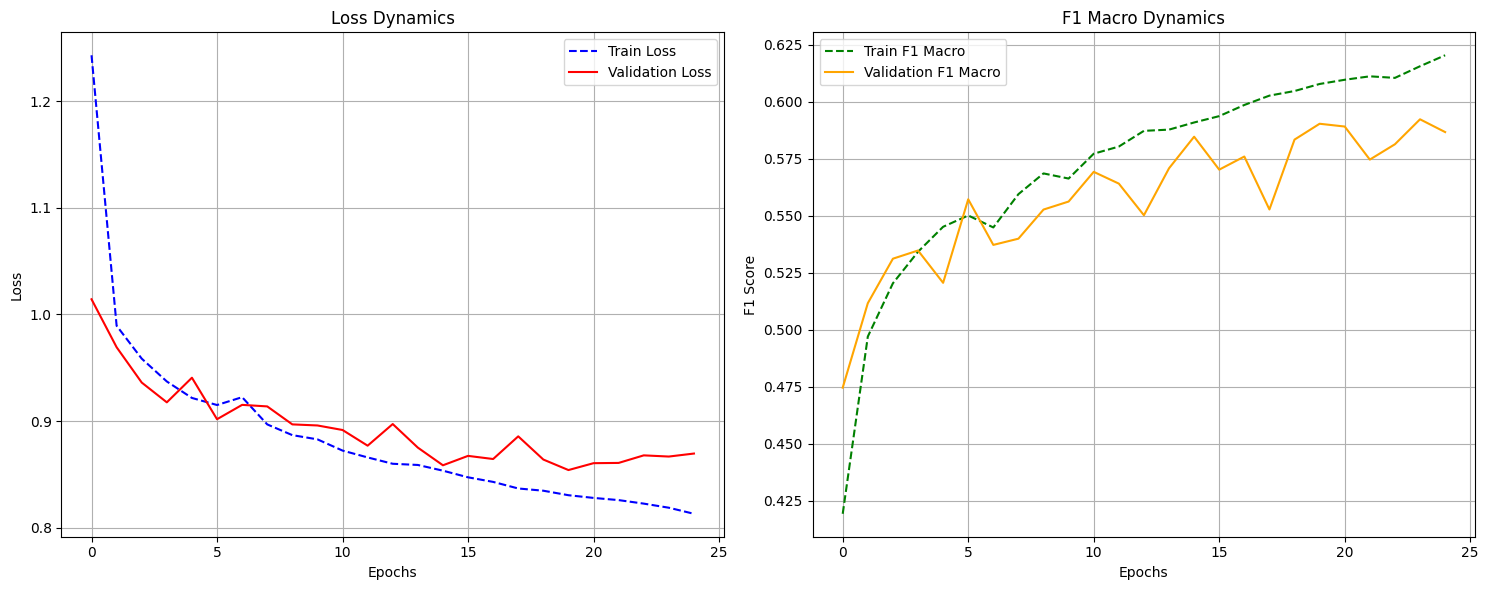

In [ ]:
# Создаем фигуру
plt.figure(figsize=(15, 6))

# График для Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для F1 Macro
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Train F1 Macro', color='green', linestyle='--')
plt.plot(history.history['val_f1_score'], label='Validation F1 Macro', color='orange', linestyle='-')
plt.title('F1 Macro Dynamics')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
Полина К.
1. Вытащите прямо архитектуру визуальную. Сколько слоев, какие, как.
2. Можете побольше инфы о том, как учили модель? Какой оптимизатор, сколько эпох и так далее.
3. Объемы обучающей выборки? Дайте статистику